# Exercise Sheet 2: Binary Classification

### Import necessary libraries

In [58]:
import numpy as np
from math import sqrt
from random import randint
import os
from typing import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from scipy.stats import mode

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 4.0)

import pprint
pp = pprint.PrettyPrinter(indent=4)

# set default theme
sns.set_theme()

In [59]:
RESULTS_PATH_T1 = 'results/task1'
RESULTS_PATH_T2 = 'results/task2'
RESULTS_PATH_T3 = 'results/task3'

## Task 1: k-NearestNeighbours 

In [60]:
# create random colours
def generate_colors(amount: int) -> list:
    colors = []
    for i in range(amount):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    return colors

In [61]:
def scatter_2D(x1, x2, y, cdict = {0: 'red', 1: 'blue'}, title='', path='./result/'):

    # if path does not exist, create it
    if not os.path.exists(path):
        os.makedirs(path)
        
    img_name = title.replace(' ', '_')
    img_path = path + img_name

    fig, ax = plt.subplots()
    for g in np.unique(y):
        ix = np.where(y == g)
        ax.scatter(x1[ix], x2[ix], c=cdict[g], marker='.', label=f'class {g}')
    ax.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

    fig.savefig(img_path, dpi=fig.dpi)

In [62]:
def scatter_2D_linspace(x1, x2, y, cdict={0: 'red', 1: 'blue'}, title='', path='./result/', line_x=np.linspace(0, 1), line_y=np.linspace(0, 1), xlim=None, ylim=None):

    # if path does not exist, create it
    if not os.path.exists(path):
        os.makedirs(path)

    img_name = title.replace(' ', '_')
    img_path = path + img_name

    fig, ax = plt.subplots(figsize=(8, 6))  # Set the figure size explicitly
    # plotting three dimensional functions
    # use meshgrid
    X, Y = np.meshgrid(line_x, line_y)
    Z1 = np.exp(X * Y)
    # Z1 = X ** 2 + (Y - X) * 2  # log scale
    z = np.ma.masked_where(Z1 <= 0, Z1)

    cs = plt.contourf(X, Y, z,
                      locator=ticker.LogLocator(),
                      cmap="bone")

    for g in np.unique(y):
        ix = np.where(y == g)
        ax.scatter(x1[ix], x2[ix], c=cdict[g], marker='.', label=f'class {g}', zorder=1)
    ax.legend()

    # Plot the resulting regression line
    plt.plot(line_x, line_y, '-', color='r', zorder=1)

    # Define area to plot
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(cs)

    # Set xlim and ylim if provided
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()  # Optimize the layout and remove unnecessary white space
    plt.show()

    fig.savefig(img_path, dpi=fig.dpi)


In [63]:
def calc_rss(y, y_pred):
    """Calculate minimal RSS Error"""
    return np.sum(np.square(y-y_pred))

In [64]:
def calc_accuracy(y, ypred):
    """Calculate the accuracy score."""
    return np.mean(y==ypred)

### k-Nearest Neighbour Algorithm

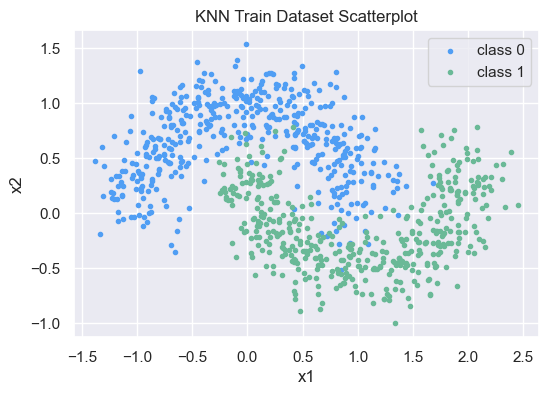

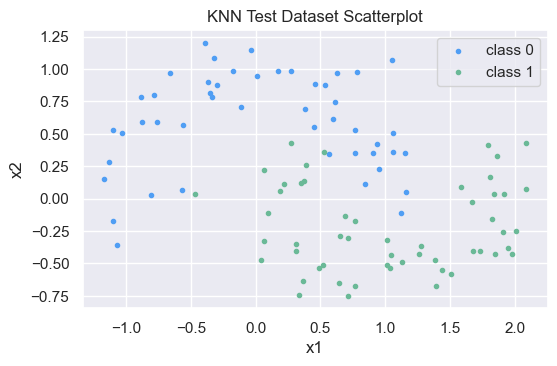

In [65]:
# 1. Visualize the dataset
import sklearn.datasets


N = 1000
N_train = int(N*0.9) #use 90% for training
N_test = N - N_train #rest for testing

# 2D dataset consisting of points x and binary labels y
x, y = sklearn.datasets.make_moons(n_samples=N, noise=0.2,random_state=0)

# create data
#split into train and test set
xtrain, ytrain = x[:N_train,...], y[:N_train,...]
xtest, ytest = x[N_train:,...], y[N_train:,...]

# randomly generate colour dict
labels = np.unique(ytrain)
colors = generate_colors(len(labels))
cdict_ = dict(zip(labels, colors))

scatter_2D(xtrain[0:,0], xtrain[0:,1], ytrain, cdict=cdict_, title='KNN Train Dataset Scatterplot', path=RESULTS_PATH_T1)
scatter_2D(xtest[0:,0], xtest[0:,1], ytest, cdict=cdict_, title='KNN Test Dataset Scatterplot', path=RESULTS_PATH_T1)


In [66]:
def euclidean_distance(vec1, vec2):
    """ Distance metric to define the similarity of two vectors
        
        Calculate the Euclidean distance between two vectors.
        >> Euclidean Distance = sqrt(sum i to N (x1_i – x2_i)^2)
        As the data points are vectors the norm can be calculated.
    """
    # return np.sqrt(np.sum((vec1-vec2)**2))
    return np.linalg.norm(vec1 - vec2) # vectorized

In [67]:

class KNN(object):
    """ Does not require any learning as the model stores the entire dataset
        and classifies data points based on the points that are similar to it.
        It makes predictions based on the training data only.
    """
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit(self, x, y):
        self.x = x
        self.y = y

    def kneighbors(self, xquery):
        """ Returns the indices and distances of the k nearest neighbor points 
            based on distances to them. Uses the euclidean distance as distance metric.
        """
        point_dist = []
        for row_j in self.x:
            # calculate distances
            point_dist.append(euclidean_distance(row_j, xquery))
        point_dist = np.array(point_dist)
        # get k neighbors by their indices
        nearest_neighbor_ids = np.argsort(point_dist)[:self.n_neighbors]
        return nearest_neighbor_ids

    def predict(self, xquery):
        """ Returns predicted label for a given query point.
        """
        predictions = []
        for i in range(len(xquery)):
            indices = self.kneighbors(xquery[i])
            pred_labels = self.y[indices.astype(int)]
            # calc mode to get most occuring values
            pred_mode_label = int(mode(pred_labels)[0])
            # np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=pred_labels)
            predictions.append(pred_mode_label)
        return predictions

    def predict_probs(self, xquery):
        """Returns class probabilities for a given query point."""
        xquery = np.atleast_2d(xquery)

        # Get indices of k-nearest neighbors for all query points
        indices = self.kneighbors(xquery)

        # Get labels of k-nearest neighbors
        neighbor_labels = self.y[indices]

        # Calculate class frequencies for each query point
        class_freqs = [Counter(neighbor_label) for neighbor_label in neighbor_labels.reshape(-1, self.n_neighbors)]

        # Convert frequencies to probabilities
        class_probas = np.array([[freq / self.n_neighbors for freq in freqs.values()] for freqs in class_freqs])

        return class_probas

In [68]:
# 2. Fit your KNN model for k = 5 to the data

k = 5

# own version
knn = KNN(n_neighbors=k)

# sklearn version
sknn = KNeighborsClassifier(n_neighbors=k)

# fit the model
knn.fit(xtrain, ytrain)
sknn.fit(xtrain, ytrain)

# 3. Predict the labels of the test data
y_pred  = knn.predict(xtest)
print(f"KNN predictions: \n{y_pred}\n")

y_pred_sk = sknn.predict(xtest)
print(f"KNN predictions: \n{y_pred_sk}\n")

KNN predictions: 
[1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]

KNN predictions: 
[1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0
 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1
 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1]



In [69]:
# 4. Compare the predicted labels with the true labels
print('Own KNN\n')
print(classification_report(ytest, y_pred))

Own KNN

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        47
           1       0.98      0.96      0.97        53

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [70]:
print('Sklearn KNN\n')
print(classification_report(ytest, y_pred_sk))

Sklearn KNN

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        47
           1       0.98      0.96      0.97        53

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



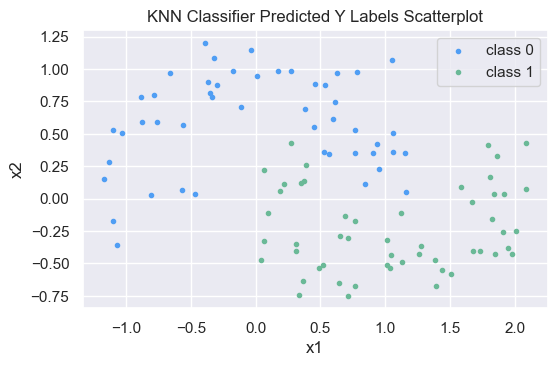

In [71]:
scatter_2D(xtest[0:,0], xtest[0:,1], y_pred, cdict=cdict_, title='KNN Classifier Predicted Y Labels Scatterplot', path=RESULTS_PATH_T1)

KNN with k: 1
The minimum RSS error for KNN is: 6
The minimum accuracy score for KNN is: 0.94


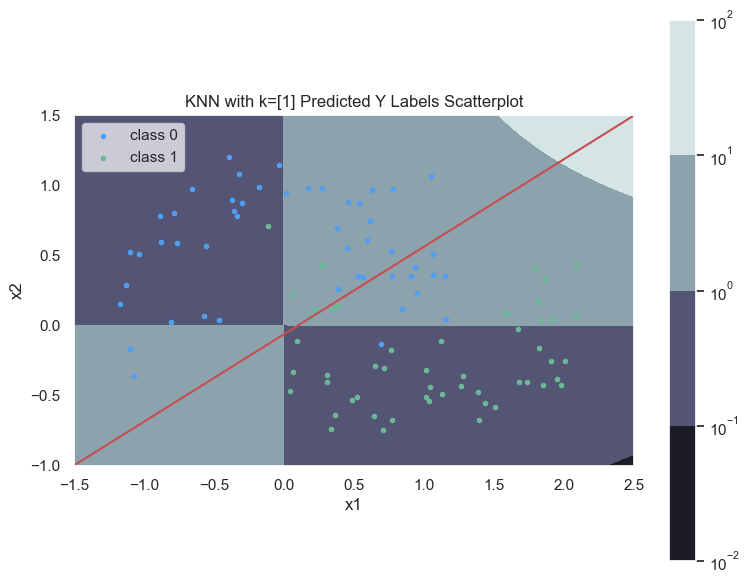

KNN with k: 2
The minimum RSS error for KNN is: 4
The minimum accuracy score for KNN is: 0.96


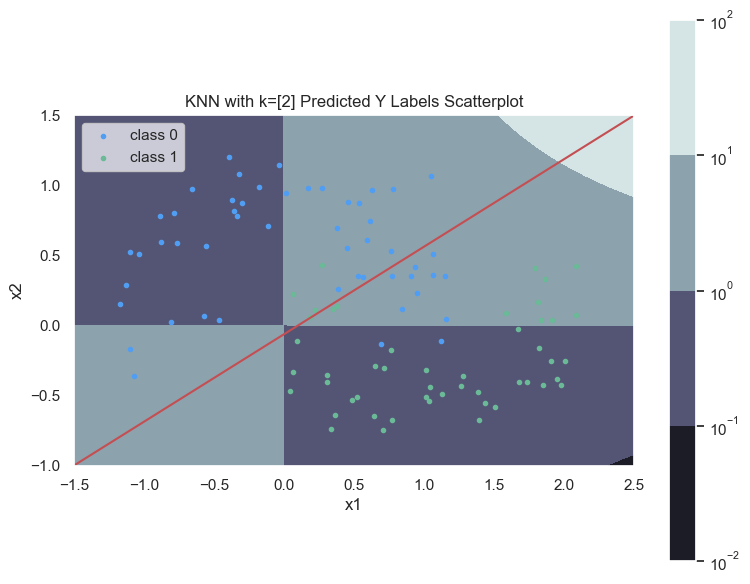

KNN with k: 4
The minimum RSS error for KNN is: 6
The minimum accuracy score for KNN is: 0.94


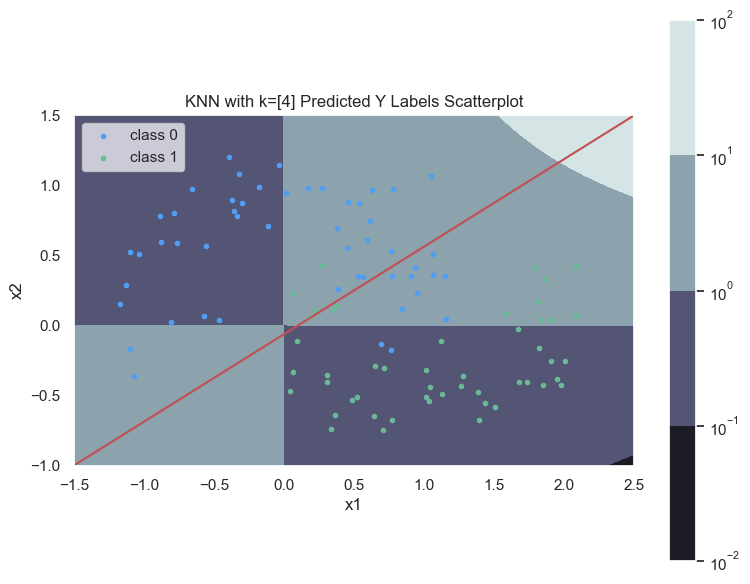

KNN with k: 8
The minimum RSS error for KNN is: 5
The minimum accuracy score for KNN is: 0.95


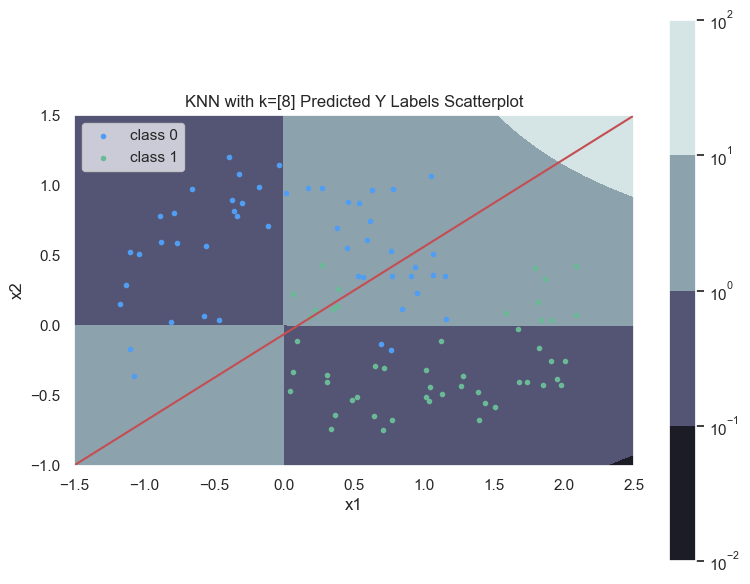

KNN with k: 16
The minimum RSS error for KNN is: 1
The minimum accuracy score for KNN is: 0.99


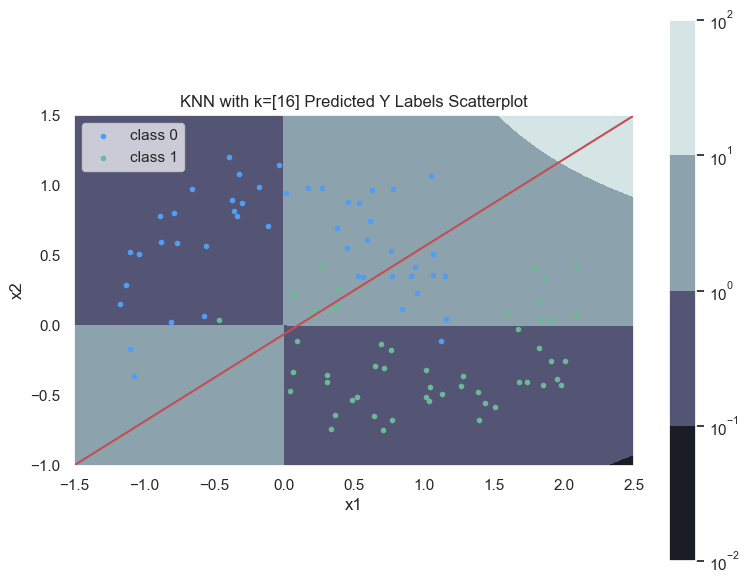

KNN with k: 32
The minimum RSS error for KNN is: 3
The minimum accuracy score for KNN is: 0.97


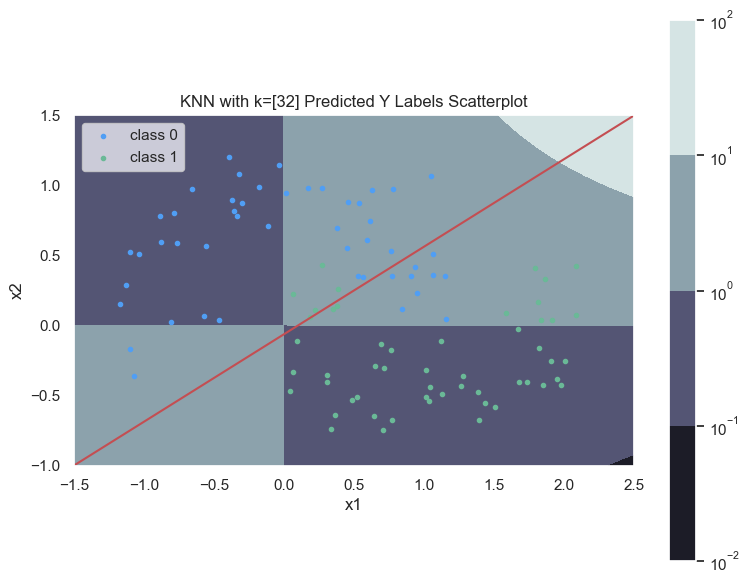

KNN with k: 64
The minimum RSS error for KNN is: 3
The minimum accuracy score for KNN is: 0.97


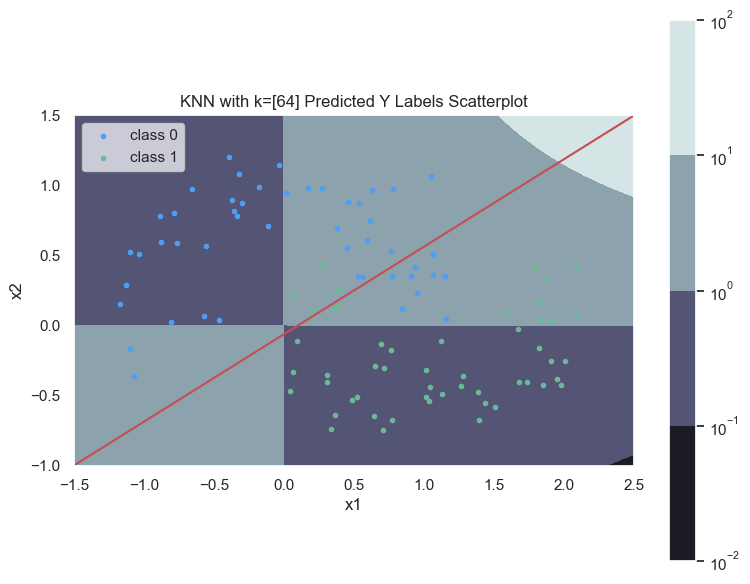

KNN with k: 128
The minimum RSS error for KNN is: 5
The minimum accuracy score for KNN is: 0.95


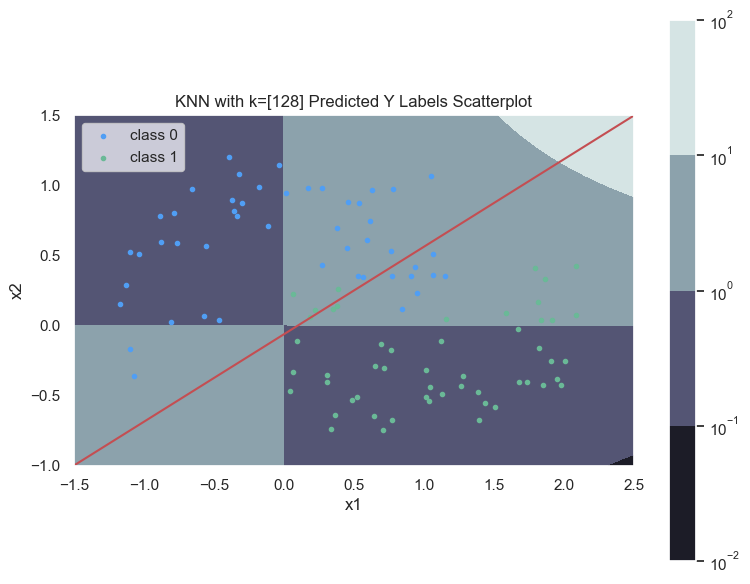

KNN with k: 256
The minimum RSS error for KNN is: 6
The minimum accuracy score for KNN is: 0.94


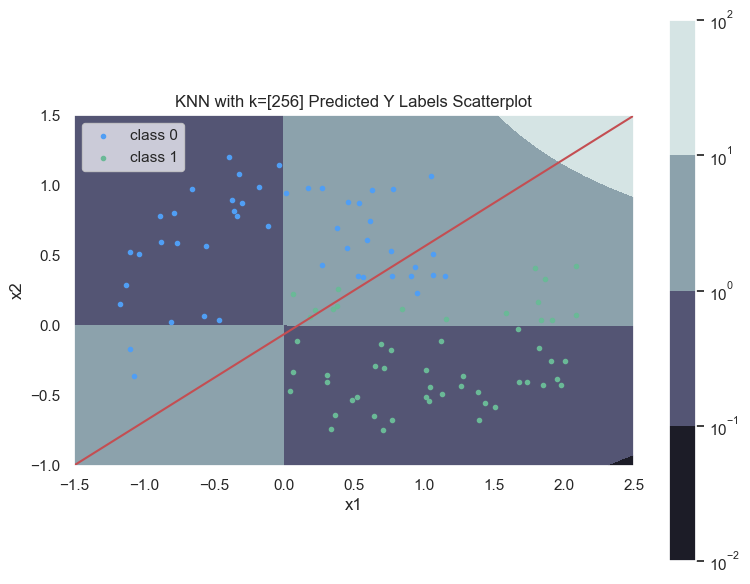

KNN with k: 512
The minimum RSS error for KNN is: 20
The minimum accuracy score for KNN is: 0.8


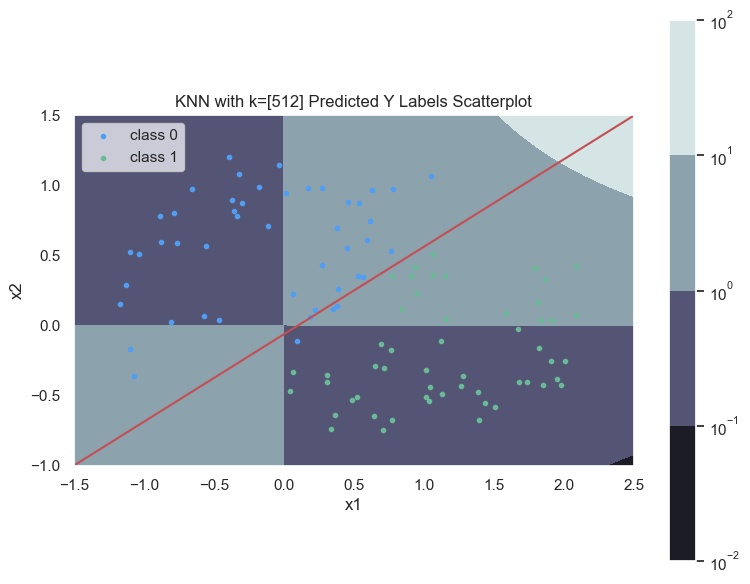

In [72]:
# 5. Analyze different values of k
ks = [pow(2, i) for i in range(10)]
accuracies = []

for k in ks:
    print("KNN with k: " + str(k))
    # fit and evaluate accuracy on test data
    knn = KNN(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    knn_ypred = knn.predict(xtest)

    rss = calc_rss(ytest, knn_ypred)
    acc = calc_accuracy(ytest, knn_ypred)
    print("The minimum RSS error for KNN is: " + str(rss))
    print("The minimum accuracy score for KNN is: " + str(acc))

    accuracies.append((k, acc))

    # plot decision boundary
    N = 100
    linx = np.linspace(-1.5, 2.5, N)
    liny = np.linspace(-1.0, 1.5, N)
    
    scatter_2D_linspace(xtest[0:,0], xtest[0:,1], knn_ypred, cdict=cdict_, title=f'KNN with k=[{k}] Predicted Y Labels Scatterplot', line_x=linx, line_y=liny, path=RESULTS_PATH_T1)

7. **How does the decision boundary change with k? What would happen if k is
equal to the number of train samples?**

As the value of k increases, the decision boundary of the classifier becomes softer and more general. This is because a larger k increasingly reduces the influence of individual data points, which leads to a lower variance in the model. However, this also leads to greater distortion, as the model is less sensitive to local patterns and outliers in the data.

Conversely, as the value of k decreases, the decision boundary becomes more complex and more closely aligned with the training data. This increases the variance of the model and makes it more sensitive to noise and outliers, but reduces the distortion.

In the extreme case, where k is equal to the number of training samples, the decision boundary would be perfectly fitted to the training data, resulting in a training error of zero. However, this would lead to severe overfitting, which would cause the model to perform poorly on unseen data. In other words, the model would have high variance and low bias, so it would not generalise well to new data.


KNN with k: 2
Class probabilities p(c): [0.5 0.5]


/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_6173/3540674309.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  p_xn_given_c.append(len(k_nearest_neighbors_c) / (sum(ytrain == c) * v_star_c))


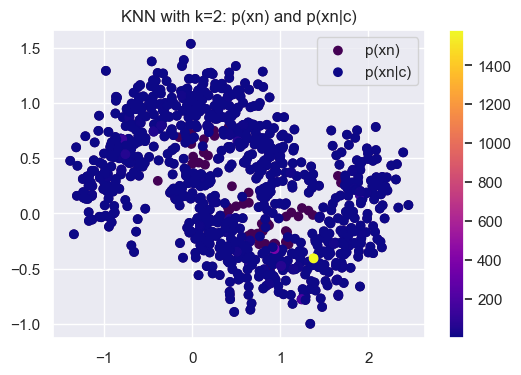

KNN with k: 4
Class probabilities p(c): [0.75 0.25]


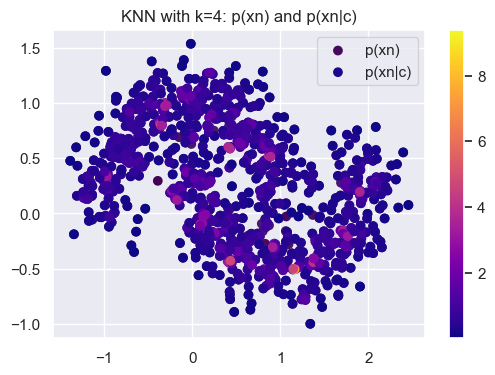

KNN with k: 8
Class probabilities p(c): [0.5 0.5]


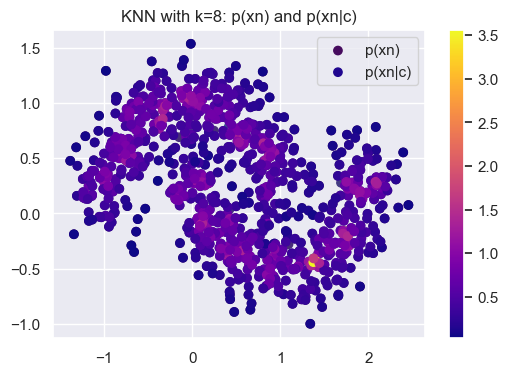

KNN with k: 16
Class probabilities p(c): [0.625 0.375]


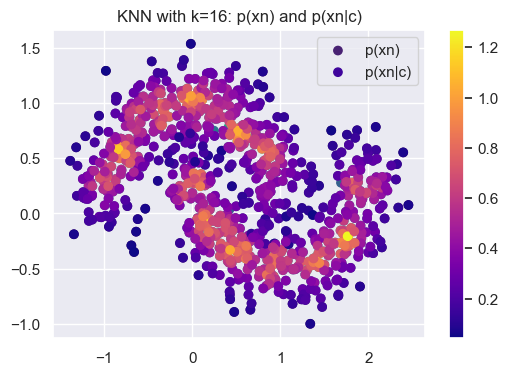

KNN with k: 32
Class probabilities p(c): [0.5 0.5]


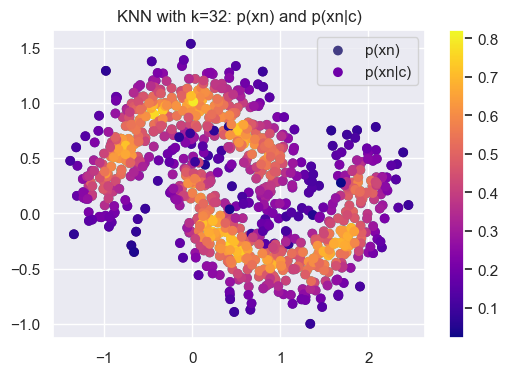

<Figure size 600x400 with 0 Axes>

In [73]:
# 8. Report class probabilities p(c) on the train set.
ks = [2, 4, 8, 16, 32]
accuracies = []

for k in ks:
    print("KNN with k: " + str(k))
    # fit and evaluate accuracy on train data
    knn = KNN(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    knn_ypred_proba = knn.predict_probs(xtrain)

    # Report class probabilities p(c) on the train set
    p_c = np.mean(knn_ypred_proba, axis=0)
    print("Class probabilities p(c):", p_c)

    # Calculate p(xn) and p(xn|c)
    p_xn = []
    p_xn_given_c = []
    for xn in xtrain:
        indices = knn.kneighbors(xn)
        k_nearest_neighbors = xtrain[indices]

        # Calculate the radius of the smallest circle including k nearest neighbors
        radius = np.max(np.linalg.norm(k_nearest_neighbors - xn, axis=1))

        # Estimate V* as the area of the smallest circle
        v_star = np.pi * (radius ** 2)

        # Calculate p(xn)
        p_xn.append(k / (len(xtrain) * v_star))

        # Calculate p(xn|c)
        c = ytrain[indices[0]]  # Assuming the first nearest neighbor determines the class
        k_nearest_neighbors_c = k_nearest_neighbors[ytrain[indices] == c]
        v_star_c = np.pi * (np.max(np.linalg.norm(k_nearest_neighbors_c - xn, axis=1)) ** 2)
        p_xn_given_c.append(len(k_nearest_neighbors_c) / (sum(ytrain == c) * v_star_c))

    # Plot p(xn) and p(xn|c)
    plt.scatter(xtrain[:, 0], xtrain[:, 1], c=p_xn, cmap='viridis', label='p(xn)')
    plt.scatter(xtrain[:, 0], xtrain[:, 1], c=p_xn_given_c, cmap='plasma', label='p(xn|c)')
    plt.colorbar()
    plt.title(f'KNN with k={k}: p(xn) and p(xn|c)')
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(RESULTS_PATH_T1, f'knn_k={k}.png'))

### Task 2: Linear Regression

In [74]:
def make_data(noise=0.2, outlier=1):
    """ Generate random training dataset with noise """
    prng = np.random.RandomState(0)
    n = 500

    x0 = np.array([0,0])[None,:] + noise*prng.randn(n, 2)
    y0 = np.ones(n)
    x1 = np.array([1,1])[None,:] + noise*prng.randn(n, 2)
    y1 = -1*np.ones(n)

    x = np.concatenate([x0,x1])
    y = np.concatenate([y0,y1]).astype(np.int32)

    xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(
        x, y, test_size=0.1, shuffle=True, random_state=0)
    xplot, yplot = xtrain, ytrain

    outlier = outlier*np.array([1,1.75])[None,:]
    youtlier = np.array([-1])
    xtrain = np.concatenate([xtrain, outlier])
    ytrain = np.concatenate([ytrain, youtlier])
    return xtrain, xtest, ytrain, ytest, xplot, yplot

In [75]:
# 1. Complete the code for the linear least squares regression
class LinearLeastSquares(object):
    """ Implementation of Linear Regression using Least Squares.
        Is a linear approach to modelling the relationship between a dependent
        variable and one or more independent variables.
    """
    def fit(self, x, y):
        """ Normal equation to find a minimizer 
            for the least square objective.
            >>> x = independent variable
            >>> y = dependent variable
        """
        # vectors that shall be combined
        # prepend ones to the input to use the bias trick
        m = len(x)
        X_w = np.array([np.ones(m), x[:, 0], x[:, 1]]).T

        # matrix inversion and calculate solution
        self.w = np.linalg.inv(X_w.T.dot(X_w)).dot(X_w.T.dot(y))
 
        return self.w
    
    def predict(self, xquery):
        # Concatenate numpy array of ones to predicted y_pred values
        # apply dot product with w to predict y values
        m = len(xquery)
        X_pred = np.array([np.ones(m), xquery[:, 0], xquery[:, 1]]).T
        
        y_pred = X_pred.dot(self.w)
        y_pred = np.rint(y_pred).astype('int8')
        
        return y_pred

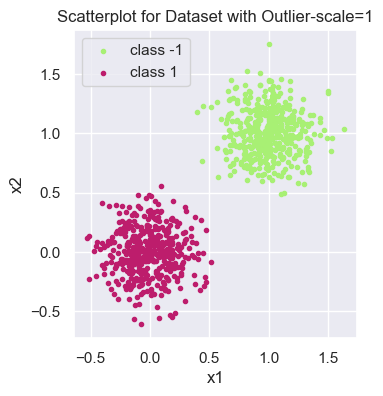

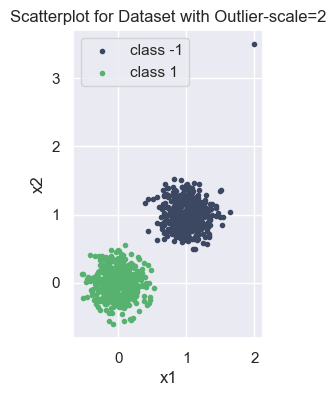

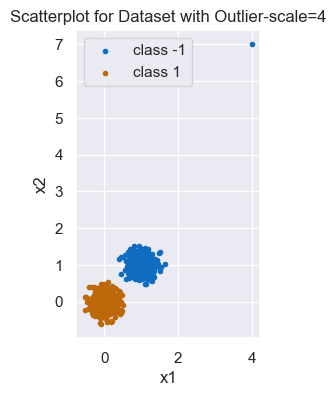

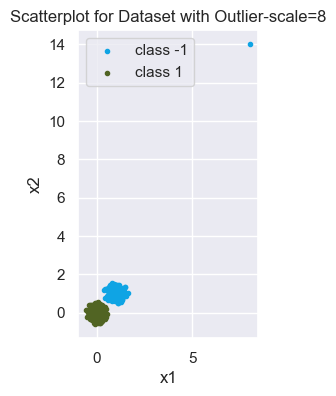

In [76]:
# 2. Visualize the dataset
data = make_data(noise=0.2, outlier=1)
n = [2**i for i in range(4)]
for outlier in n:
    # get data. xplot, yplot is same as xtrain, ytrain but without outlier
    xtrain, xtest, ytrain, ytest, xplot, yplot = make_data(outlier=outlier)
    title = f'Scatterplot for Dataset with Outlier-scale={outlier}'
    
    # randomly generate colour dict
    labels = np.unique(ytrain)
    colors = generate_colors(len(labels))
    cdict_ = dict(zip(labels, colors))

    scatter_2D(xtrain[0:,0], xtrain[0:,1], ytrain, cdict=cdict_, title=title, path=RESULTS_PATH_T2)

The RSS error is: 5
The accuracy score is: 0.95


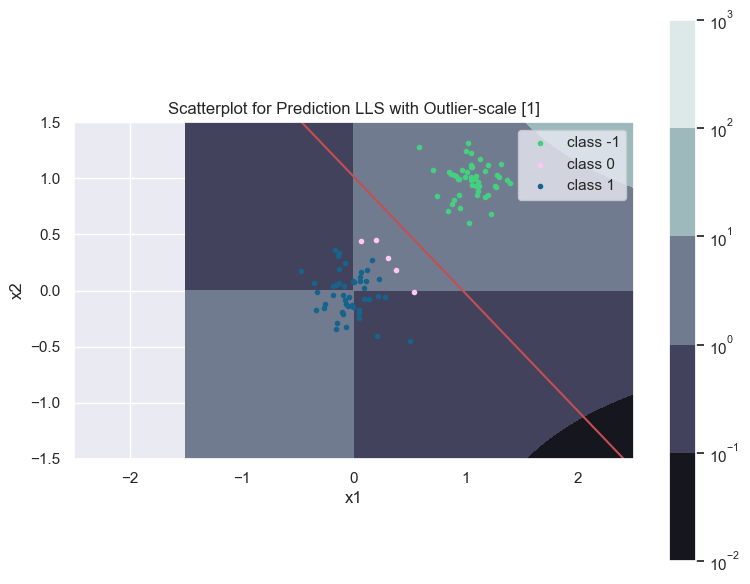

The RSS error is: 5
The accuracy score is: 0.95


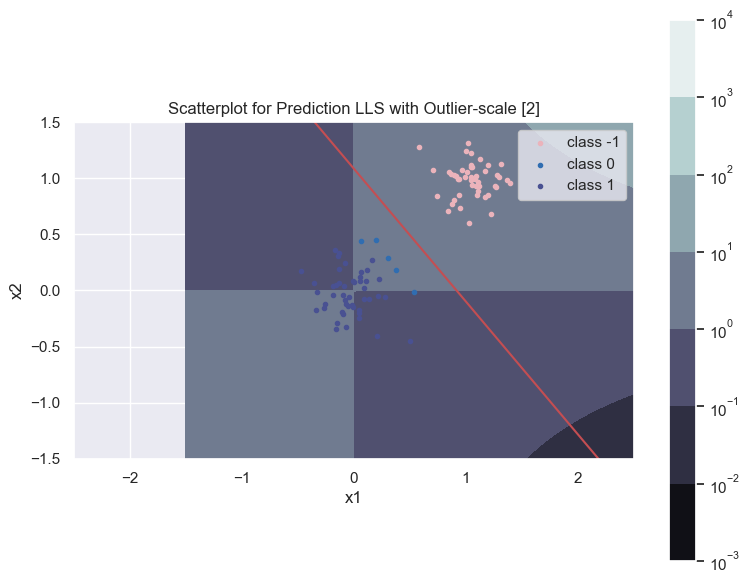

The RSS error is: 5
The accuracy score is: 0.95


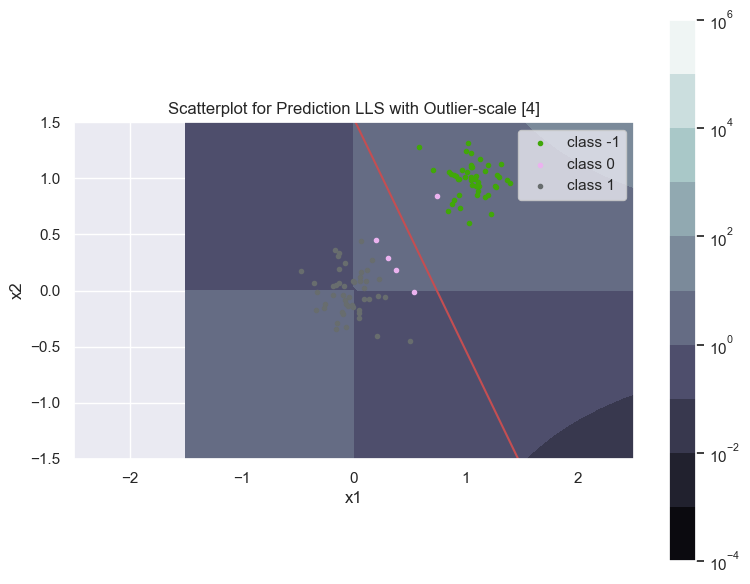

The RSS error is: 15
The accuracy score is: 0.85


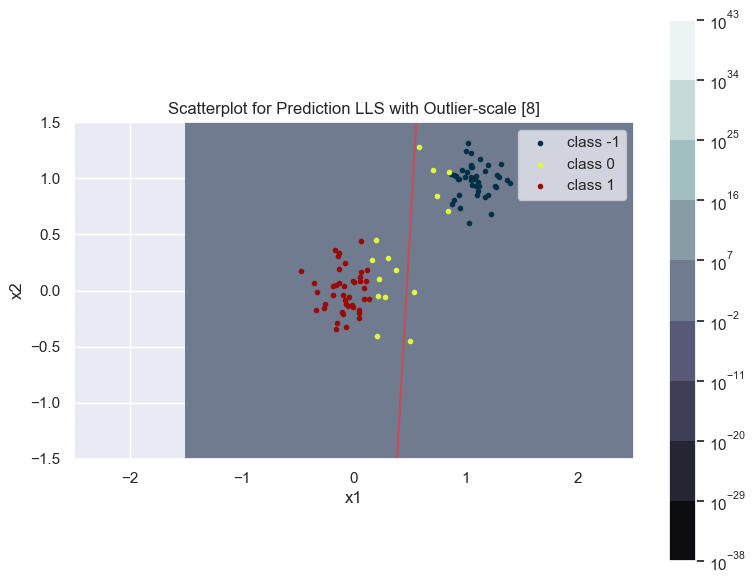

In [77]:
for outlier in n:
    # get data. xplot, yplot is same as xtrain, ytrain but without outlier
    xtrain, xtest, ytrain, ytest, xplot, yplot = make_data(outlier=outlier)

    lls = LinearLeastSquares()
    beta = lls.fit(xtrain, ytrain)

    # evaluate accuracy and decision boundary of LLS
    ypred = lls.predict(xtest)

    # randomly generate colour dict
    labels = np.unique(ypred)
    colors = generate_colors(len(labels))
    cdict_ = dict(zip(labels, colors))

    rss = calc_rss(ytest, ypred)
    acc = calc_accuracy(ytest, ypred)
    print("The RSS error is: " + str(rss))
    print("The accuracy score is: " + str(acc))

    path='./code_task2/result/'
    title = f'Scatterplot for Prediction LLS with Outlier-scale [{outlier}]'
    
    # Plot the resulting regression line
    N = 100
    # linx = np.linspace(-1.5, 2.5, N)
    # liny = np.linspace(-1.0, 1.5, N)
    
    linx = np.linspace(-1.5, 2.5, N)
    liny = -beta[0] / beta[2] - (beta[1] / beta[2]) * linx

    scatter_2D_linspace(xtest[0:,0], xtest[0:,1], ypred, cdict=cdict_, title=title, line_x=linx, line_y=liny, path=RESULTS_PATH_T2, xlim=[-2.5, 2.5], ylim=[-1.5, 1.5])

4. **How is the fit affected by the outlier? Give a short explanation?**

Outliers are observed data points that significantly deviate from the general trend in the dataset, appearing far away from the least squares line. Due to their large vertical distance from the line, outliers have substantial error values (residuals), which can significantly influence the regression equation. This influence is particularly pronounced in small datasets, where a single outlier can considerably impact the overall fit.

When outliers are present, the least squares prediction is shifted towards them, causing the variance of the estimates to be artificially inflated. Consequently, the prediction accuracy decreases as the value of the outliers increases. This effect is evident in the provided plots, where outliers ranging from [1, 16] demonstrate a clear decline in prediction accuracy as their values increase. In summary, outliers can negatively impact the fit of a regression model, leading to reduced prediction accuracy and inflated variance in the estimates.

### Task 3: Softmax Regression & Optimization

1. Derive a formula for the gradient $\frac{\partial \mathcal{L}}{\partial \theta_c}$. To do so, just derive the solution for a single example $L_i$ and apply the chain rule of calculus $\frac{\partial \mathcal{L}}{\partial \theta} = \frac{\partial \mathcal{L}}{\partial p} \frac{\partial p}{\partial g} \frac{\partial g}{\partial \theta}$ with $g = \theta_0 + \sum_{j=1}^{D} \theta_j x_j$. For this task, it is enough if you report derivatives of each chain rule component alone to get full points.

\begin{align*}
\frac{\partial \mathcal{L}}{\partial \theta_c} &= \frac{\partial \mathcal{L}}{\partial p} \frac{\partial p}{\partial g} \frac{\partial g}{\partial \theta_c} \\
\end{align*}

Where:

- $\mathcal{L}$ is the cross-entropy loss function for a single example.
- $p$ is the predicted probability of the true class $c$.
- $g$ is the logit (input to the softmax function) for class $c$.


The softmax function is defined as:

$$\text{softmax}(g_i) = \frac{e^{g_i}}{\sum_{j=1}^{C} e^{g_j}}$$

Where:

* $g_i$ is the logit (input to the softmax function) for class $i$.
* $C$ is the total number of classes.

(1) Calculate the derivative of the softmax function with respect to the logit $g_c$ for class $c$:

$$\frac{\partial \text{softmax}(g_c)}{\partial g_c} = \frac{\partial}{\partial g_c} \left( \frac{e^{g_c}}{\sum_{j=1}^{C} e^{g_j}} \right)$$

For the case when $i=j$ (i.e., calculating the derivative with respect to the same class $c$):

$$\frac{\partial \text{softmax}(g_c)}{\partial g_c} = \frac{e^{g_c} \sum_{j=1}^{C} e^{g_j} - e^{g_c} e^{g_c}}{(\sum_{j=1}^{C} e^{g_j})^2} = \text{softmax}(g_c) (1 - \text{softmax}(g_c))$$

For the case when $i\neq j$ (i.e., calculating the derivative with respect to a different class $k$):

$$\frac{\partial \text{softmax}(g_c)}{\partial g_k} = \frac{\partial}{\partial g_k} \left( \frac{e^{g_c}}{\sum_{j=1}^{C} e^{g_j}} \right) = \frac{-e^{g_c} e^{g_k}}{(\sum_{j=1}^{C} e^{g_j})^2} = -\text{softmax}(g_c) \text{softmax}(g_k)$$

(2) Calculate the derivative of the cross-entropy loss function with respect to the logit $g_c$:

$$\frac{\partial L}{\partial g_c} = \frac{\partial L}{\partial p} \frac{\partial p}{\partial g_c}$$

Where:

* $L$ is the cross-entropy loss function for a single example.
* $p$ is the predicted probability of the true class $c$.

The cross-entropy loss function is defined as:

$$L = -\log(p)$$

The derivative of the cross-entropy loss function with respect to the predicted probability $p$ is:

$$\frac{\partial L}{\partial p} = -\frac{1}{p}$$

Use the derivatives of the softmax function calculated earlier to find the derivative of the cross-entropy loss function with respect to the logit $g_c$.

For the case when $i=j$ (i.e., calculating the derivative with respect to the same class $c$):

$$\frac{\partial L}{\partial g_c} = -\frac{1}{p} \cdot \text{softmax}(g_c) (1 - \text{softmax}(g_c)) = -(1 - \text{softmax}(g_c))$$

For the case when $i\neq j$ (i.e., calculating the derivative with respect to a different class $k$):

$$\frac{\partial L}{\partial g_k} = -\frac{1}{p} \cdot (-\text{softmax}(g_c) \text{softmax}(g_k)) = \text{softmax}(g_k)$$

Use these derivatives to calculate the gradient of the cross-entropy loss function with respect to the model parameters $\theta_c$ for class $c$:

$$\frac{\partial L}{\partial \theta_c} = \frac{\partial L}{\partial g_c} \frac{\partial g_c}{\partial \theta_c}$$

Where:

* $g_c$ is the logit (input to the softmax function) for class $c$.

Recall that the logit $g_c$ is defined as:

$$g_c = \theta_0 + \sum_{j=1}^{D} \theta_j x_j$$

The derivative of the logit $g_c$ with respect to the model parameters $\theta_c$ is:

$$\frac{\partial g_c}{\partial \theta_c} = x$$

Use the derivatives of the cross-entropy loss function with respect to the logit $g_c$ calculated earlier to find the gradient of the cross-entropy loss function with respect to the model parameters $\theta_c$.

For the case when $i=j$ (i.e., calculating the gradient with respect to the same class $c$):

$$\frac{\partial L}{\partial \theta_c} = -(1 - \text{softmax}(g_c)) \cdot x = x \cdot (\text{softmax}(g_c) - 1)$$

For the case when $i\neq j$ (i.e., calculating the gradient with respect to a different class $k$):

$$\frac{\partial L}{\partial \theta_k} = \text{softmax}(g_k) \cdot x = x \cdot \text{softmax}(g_k)$$

These are the gradients of the cross-entropy loss function with respect to the model parameters for both cases when $i=j$ and $i\neq j$.



In [78]:
def stable_softmax(logits):
    """ Compute the softmax of vector x in a numerically stable way.
        Prevent overflow and underflow by subtracting the maximum value from the logits.
    """
    logits_max = np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits - logits_max)
    sum_exp_logits = np.sum(exp_logits, axis=1, keepdims=True)
    return exp_logits / sum_exp_logits


In [79]:
# 2. Load digits dataset (load_digits) from sklearn.datasets
data = load_digits()
x, y = (data.images / 16.0).reshape(-1, 8 * 8), data.target

# Split the dataset into training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=0)

In [80]:
# 3. Implement an optimization routine using gradient descent.

# initialize parameters
weights = np.random.normal(0, 1, size=(10, x.shape[1]))
bias = np.zeros((10,))

# set learning rate and number of iterations
lr = 0.01
num_iterations = 1000

# iterate through number of iterations
for i in range(num_iterations):

    # calculate logits and probabilities
    logits = xtrain @ weights.T + bias
    probs = stable_softmax(logits)

    # calculate the gradient with respect to weights and bias
    ytrain = ytrain.reshape(-1, 1)
    grad_weights = xtrain.T @  (probs - ytrain)
    grad_bias = np.sum(probs - ytrain, axis=0)

    # update the parameters using gradient descent
    weights -= lr * grad_weights.T
    bias -= lr * grad_bias

# evaluate the model on the test set
test_logits = xtest @ weights.T + bias
test_probs = stable_softmax(test_logits)
test_predictions = np.argmax(test_probs, axis=1)
test_accuracy = np.mean(test_predictions == ytest)

print("Test accuracy:", test_accuracy)



Test accuracy: 0.10666666666666667
